<a href="https://colab.research.google.com/github/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification to detect sensitive data exposure

## Importing libraries and downloading the dataset

In [152]:

import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import json

## Preprocessing the dataset

In [153]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  d=[]
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords: #Remove stop words in sentence
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    d.append([sentence,label])
  return d
# Load sensitive and non-sensitive data from JSON files
sen = loadDataset('SensitiveDataset.json')
nonsen = loadDataset('NonSensitiveDatasetnew.json')

In [164]:
import pandas as pd
sen=pd.DataFrame(data=sen,columns=['sentences','labels'])
nonsen=pd.DataFrame(data=nonsen,columns=['sentences','labels'])
df= pd.concat([sen, nonsen], axis=0)
df=df.sample(frac=1).reset_index(drop=True)
df_sen=df[df['labels']==1]
df_non=df[df['labels']==0]


# Splitting into features (X) and labels (y)
X = df_balanced['sentences'].values
y = df_balanced['labels'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [165]:
# Tokenizing the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
#tokenizer.fit_on_texts(X_test)
word_dict = tokenizer.index_word
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [166]:
# Padding the data
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=100, padding='post')
X_test = pad_sequences(X_test, maxlen=100, padding='post')

In [167]:
max_num=max([max(seq) for seq in X_train])
max_num

108549

## Model

In [168]:
import tensorflow as tf
#import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
from keras.regularizers import l1
from keras.constraints import max_norm
# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(max_num+1, 64, input_length=100),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(32, 5, activation='relu',kernel_regularizer=l1(0.01),kernel_constraint=max_norm(2.)),
    tf.keras.layers.Dropout(0.3),
    # Global average pooling operation (Flattening)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 64)           6947200   
                                                                 
 batch_normalization_42 (Ba  (None, 100, 64)           256       
 tchNormalization)                                               
                                                                 
 conv1d_14 (Conv1D)          (None, 96, 32)            10272     
                                                                 
 dropout_28 (Dropout)        (None, 96, 32)            0         
                                                                 
 batch_normalization_43 (Ba  (None, 96, 32)            128       
 tchNormalization)                                               
                                                                 
 global_average_pooling1d_1  (None, 32)              

## Training

In [169]:
num_epochs = 5

# model.fit - Train the model for a fixed number of epochs
history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=64,
                    validation_data=(X_test,y_test), 
                    verbose=1)
                    #callbacks=[callbacks])

Epoch 1/10
346/346 [==============================] - 35s 88ms/step - loss: 1.3293 - accuracy: 0.9661 - val_loss: 0.9331 - val_accuracy: 0.4898
Epoch 2/10
346/346 [==============================] - 31s 88ms/step - loss: 0.1546 - accuracy: 0.9980 - val_loss: 0.1664 - val_accuracy: 1.0000
Epoch 3/10
346/346 [==============================] - 31s 91ms/step - loss: 0.0897 - accuracy: 0.9995 - val_loss: 0.0765 - val_accuracy: 0.9988
Epoch 4/10
346/346 [==============================] - 31s 89ms/step - loss: 0.0988 - accuracy: 0.9996 - val_loss: 0.0676 - val_accuracy: 1.0000
Epoch 5/10
346/346 [==============================] - 33s 95ms/step - loss: 0.0703 - accuracy: 0.9996 - val_loss: 0.1044 - val_accuracy: 0.9914
Epoch 6/10
346/346 [==============================] - 30s 88ms/step - loss: 0.1292 - accuracy: 0.9993 - val_loss: 0.2232 - val_accuracy: 0.9701
Epoch 7/10
346/346 [==============================] - 31s 89ms/step - loss: 0.0854 - accuracy: 0.9995 - val_loss: 0.0629 - val_accuracy:

## Plotting Accuracy and Loss Functions

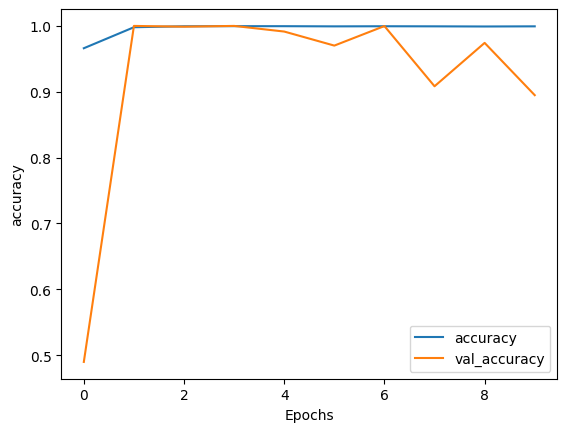

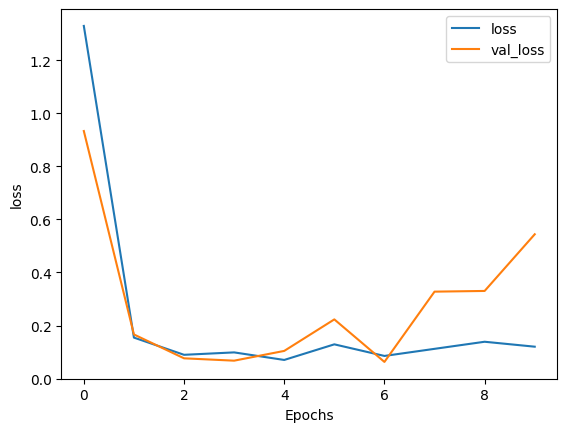

In [170]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)                      
  plt.legend([string, 'val_'+string])       
  plt.show()                               
                                          
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Confusion Matrix

Confusion Matrix
297/297 [==============================] - 4s 11ms/step
Threshold [0.50001425]
Accuracy for Test Data =  89.48590731552835


Text(95.72222222222221, 0.5, 'Expected')

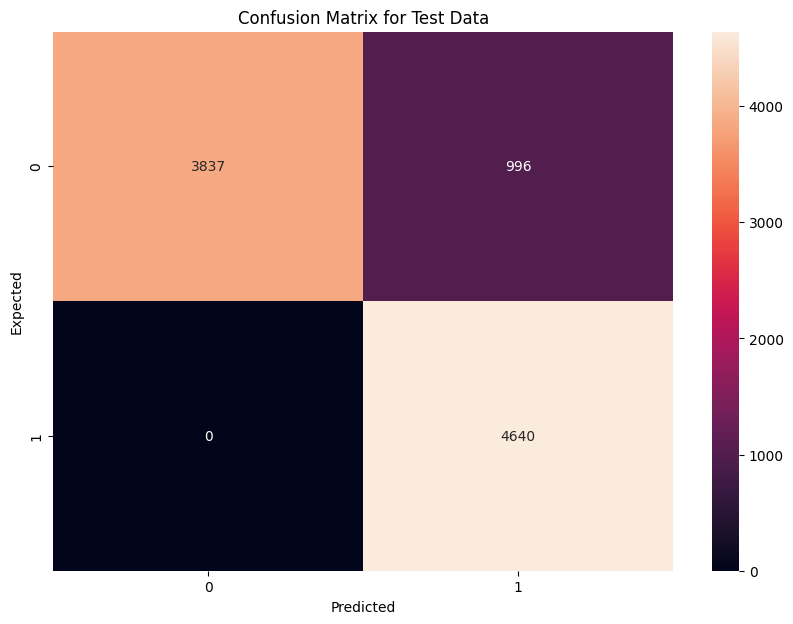

In [171]:
import seaborn
import pandas as pd
print('Confusion Matrix')
y_predicted = model.predict(X_test)
print("Threshold",(min(y_predicted)+max(y_predicted))/2)
y_predicted_labels = y_predicted > 0.5
size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

cm = tf.math.confusion_matrix(y_test,y_predicted_labels)
cm_np = cm.numpy()
conf_acc = ((cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np)) * 100
print("Accuracy for Test Data = ", conf_acc)
plt.figure(figsize = (10,7))
seaborn.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix for Test Data")
plt.xlabel('Predicted')
plt.ylabel('Expected')

In [175]:
from sklearn.metrics import classification_report,accuracy_score
report = classification_report(y_test,y_predicted_labels)
print("Classification Report:\n", report)
print("Accuracy Score:", accuracy_score(y_test,y_predicted_labels)*100)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89      4833
           1       0.82      1.00      0.90      4640

    accuracy                           0.89      9473
   macro avg       0.91      0.90      0.89      9473
weighted avg       0.91      0.89      0.89      9473

Accuracy Score: 89.48590731552835


## Sample Example

In [180]:
test = ['hi im Lasya', 'mobile number is 1234567890', 'my email id is krishna@gmail.com','7789 6543 1234','I would like to have a cup of coffee in the morning','Sastra University Thanjavur']
sensitive=[]
nonsensitive=[]
for i in test:
    seq = tokenizer.texts_to_sequences([i])
    pad = pad_sequences(seq, maxlen=20, padding='post')
    pred = model.predict(pad)
    if pred > 0.5:
        sensitive.append(i)
        print(i, 'Sensitive')
    else:
        nonsensitive.append(i)
        print(i, 'Non-sensitive')

1/1 [==============================] - 0s 159ms/step
hi im Lasya Non-sensitive
1/1 [==============================] - 0s 186ms/step
mobile number is 1234567890 Sensitive
1/1 [==============================] - 0s 110ms/step
my email id is krishna@gmail.com Sensitive
1/1 [==============================] - 0s 86ms/step
7789 6543 1234 Non-sensitive
1/1 [==============================] - 0s 178ms/step
I would like to have a cup of coffee in the morning Sensitive
1/1 [==============================] - 0s 77ms/step
Sastra University Thanjavur Non-sensitive


In [21]:
df=pd.DataFrame(sensitive)

In [47]:
from cryptography.fernet import Fernet  
df_sen = df
df_sen.to_csv('blood-banks.csv',index=False)
df_sen = pd.read_csv('blood-banks.csv')
# Generate a key
key = Fernet.generate_key()
# Save the key to a file
with open("key.key", "wb") as key_file:
    key_file.write(key)
# Load the key from the file
with open("key.key", "rb") as key_file:
    key = key_file.read()
# Create a cipher suite
cipher_suite = Fernet(key)
# Encrypt the data
cipher_text = cipher_suite.encrypt(df_sen.to_csv().encode())
# Save the encrypted data to a file
with open("new.csv.encrypted", "wb") as file:  
    file.write(cipher_text)
print("Data Encrypted and Saved")
# Load the encrypted data from the file
with open("new.csv.encrypted", "rb") as file:
    cipher_text = file.read()
# Decrypt the data
plain_text = cipher_suite.decrypt(cipher_text)
# Save the decrypted data to a file
with open("new.csv.decrypted", "wb") as file:
    file.write(plain_text)
print("Data Decrypted and Saved")
# Save the model
model.save("model.h5")
print("Model Saved")

Data Encrypted and Saved
Data Decrypted and Saved


c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved


In [23]:
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np
def process_csv(file_path):
    df = pd.read_csv(file_path, encoding='latin1')  # Specify the encoding parameter
    feature_names = df.columns.tolist()
    return feature_names
def process_txt(file_path):
    with open(file_path, 'r', encoding='latin1') as file:  # Specify the encoding parameter
        text = file.read()
    tokens = word_tokenize(text)
    return tokens
def process_file(file_path):
    if file_path.endswith('.csv'):
        feature_names = process_csv(file_path)
        return feature_names
    elif file_path.endswith('.txt'):
        tokens = process_txt(file_path)
        return tokens
    elif file_path.endswith('.json'):
        # Add your code to process JSON files here
        pass
    else:
        print("Unsupported file format.")
# Get the file path from the user
file_path = input("Enter the path of the file: ")
# Process the file
features = process_file(file_path)
data_array = np.array(features)

data_input = data_array.reshape(1, -1)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(features)

# Encoding
sequences = tokenizer.texts_to_sequences(features)

# Find the length of the longest sequence
max_length = max(len(sequence) for sequence in sequences)

data_input = pad_sequences(sequences, maxlen=max_length)

# Make predictions using the model
preds = model.predict(data_input)

# Print the predictions
print(preds)

for i in range(len(preds)):
  print(preds[i][0])
  if preds[i][0]>0.5:
    print("Sensitive - "+ features[i])
  else:
    print("Non-Sensitive - " + features[i] )

1/1 [==============================] - 0s 160ms/step
[[9.9996805e-01]
 [7.2507675e-07]
 [9.9719614e-01]
 [4.7900808e-06]
 [6.9464035e-03]
 [3.2631056e-09]
 [6.3181359e-01]
 [7.9256975e-15]
 [9.9028814e-01]
 [9.7337312e-01]
 [9.9995404e-01]
 [9.9462533e-01]
 [3.0298886e-05]
 [8.4868876e-09]
 [4.6167708e-05]
 [4.9516521e-20]
 [6.6965491e-05]
 [1.2096444e-08]
 [9.8922360e-01]
 [5.0110610e-13]
 [6.4757252e-05]
 [2.7347518e-11]
 [2.3039658e-01]
 [1.6354246e-06]
 [9.5620278e-10]
 [9.2300525e-06]
 [9.2216420e-01]]
0.99996805
Sensitive - Sr No
7.2507675e-07
Non-Sensitive -  Blood Bank Name
0.99719614
Sensitive -  State
4.7900808e-06
Non-Sensitive -  District
0.0069464035
Non-Sensitive -  City
3.2631056e-09
Non-Sensitive -  Address
0.6318136
Sensitive - Pincode
7.9256975e-15
Non-Sensitive -  Contact No
0.99028814
Sensitive -  Mobile
0.9733731
Sensitive -  Helpline
0.99995404
Sensitive -  Fax
0.99462533
Sensitive -  Email
3.0298886e-05
Non-Sensitive -  Website
8.486888e-09
Non-Sensitive -  Nodal

Healthcare dataset

In [24]:
df=pd.read_csv('healthcare_dataset.csv')
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Tiffany Ramirez,81,Female,O-,Diabetes,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive
1,Ruben Burns,35,Male,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal
2,Chad Byrd,61,Male,B-,Obesity,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal
3,Antonio Frederick,49,Male,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal
4,Mrs. Brandy Flowers,51,Male,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal


In [25]:
# make name,age,medical condition,doctor,hospital,medication,test results as sensitive
# make remaining as non-sensitive
df.columns

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results'],
      dtype='object')

In [26]:
import pandas as pd
import json

# Assuming df is your DataFrame
sensitive_columns = ['Name', 'Age', 'Medical Condition', 'Doctor', 'Hospital', 'Medication', 'Test Results','Billing Amount']

json_list = []

for _, row in df.iterrows():
    data_str = ', '.join(f'{column}:{row[column]}' for column in sensitive_columns)
    json_list.append({"is_sensitive": 1, "data": data_str})

# Save to JSON file
with open('data.json', 'w') as f:
    json.dump(json_list, f)

In [27]:
non_sensitive_columns = [col for col in df.columns if col not in sensitive_columns]

json_list = []

for _, row in df.iterrows():
    data_str = ', '.join(f'{column}:{row[column]}' for column in non_sensitive_columns)
    json_list.append({"is_sensitive": 0, "data": data_str})

# Save to JSON file
with open('non_sensitive_data.json', 'w') as f:
    json.dump(json_list, f)

In [28]:
import json
dataList = []
sentences = []
labels = []
def loadDataset(filename):
  d=[]
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    d.append([sentence,label])
  return d
# Loading both sensitive and non-sensitive dataset
sen=loadDataset("SensitiveDataset.json")
nonsen=loadDataset("NonSensitiveDatasetnew.json")
sen=pd.DataFrame(data=sen,columns=['sentences','labels'])
nonsen=pd.DataFrame(data=nonsen,columns=['sentences','labels'])

In [29]:
combined = pd.concat([sen, nonsen])
df = combined.sample(frac=1).reset_index(drop=True)
df.head()

,sentences,labels
0,"card no:7009 8542 8779 9343, expiry month:jun-...",1
1,Doug Kinney (Michael Keaton) is a Los Angeles ...,0
2,"melisse, coleen, melisse@planet.nl, 876...",1
3,When a renegade Japanese gang known as the Kat...,0
4,"In 1922, Joe O'Reilly attempts to console Kitt...",0


In [30]:
tokenized_data = [word_tokenize(sentence) for sentence in df['sentences']]
stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
punctuations.remove('@')
stop_words.update(punctuations)
stemmer = PorterStemmer()
filtered_data = [[stemmer.stem(word) for word in sentence if word.lower() not in stop_words] for sentence in tokenized_data]
l=[]
for idx, sentence in enumerate(filtered_data):
    l.append(' '.join(sentence))
df['sentences'] = l

In [31]:
df.head() 

,sentences,labels
0,card no:7009 8542 8779 9343 expiri month jun-2...,1
1,doug kinney michael keaton lo angel construct ...,0
2,meliss coleen meliss @ planet.nl 8763853605,1
3,renegad japanes gang known katana take control...,0
4,1922 joe o'reilli attempt consol kitti kiernan...,0


In [32]:
df_train = df.sample(frac=.8, random_state=11)
df_test = df.drop(df_train.index)
print(df_train.shape, df_test.shape)

(25261, 2) (6315, 2)


In [33]:
y_train = df_train['labels'].values
y_test = df_test['labels'].values
y_test.shape

(6315,)

In [34]:
X_train = df_train['sentences'].values
X_test = df_test['sentences'].values

In [35]:
source=len(X_train)
max_len= max(len(seq) for seq in X_train)
print(source,max_len)

25261 10115


In [36]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_dict = tokenizer.index_word

In [37]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print(X_train_seq[:5])
print(df_train.iloc[0,:])
for el in X_train_seq[0]:
    print(word_dict[el], end=' ')

[[35494, 47337, 35494, 4893, 156, 47338], [102, 940, 55, 9, 149, 2807, 2688, 2393, 300, 707, 23684, 270, 3880, 652, 96, 3043, 1777, 558, 20007, 5502, 1207, 288, 151, 25, 5179, 6917, 343, 16769, 2758, 93, 825, 23, 3043, 1402, 23684, 20007, 1339, 16769, 20, 103, 8, 86, 2732, 24, 217, 1455, 172, 599, 447, 262, 16769, 1621, 8329, 20007, 199, 1954, 509, 3642, 1516, 49, 325, 297, 5827, 1223, 23684, 1585, 44, 6509, 1005, 2393, 8168, 75, 1198, 2612, 599, 16769, 48, 11, 491, 1224, 17, 167, 124, 246, 120, 151, 838, 3662, 33, 212, 212, 66, 26, 5776, 38, 217, 2286, 3077, 23684, 20007, 33, 75, 26, 155, 16769, 11, 350, 142], [175, 10, 15249, 15250, 13, 2, 10, 15250, 104, 182, 2389, 807, 4684, 747, 166, 35495, 35496, 47339], [804, 51, 5055, 1343, 17693, 403, 10311, 762, 180, 47, 155, 3548, 1523, 17, 84, 7392, 16, 20008, 51, 87, 543, 1343, 176, 61, 1418, 11, 3739, 100, 745, 569, 11, 1343, 121, 543, 833, 84, 255, 501, 15251, 500, 1076, 4607, 550, 1343, 30, 452, 6423, 543, 8, 5410, 1343, 6, 84, 5136, 15

In [38]:
X_train_pad = pad_sequences(X_train_seq, maxlen=20, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=20, padding='post')
X_train_pad[:5]
X_train_pad.shape[0]
#get max number in X_train_pad and X_test_pad
max_num=max([max(seq) for seq in X_train_pad])
max_num

81753

In [39]:
X_test_pad.shape

(6315, 20)

In [40]:
DESIRED_ACCURACY = 0.99
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(max_num+1,64, input_length=20),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # Global average pooling operation (Flattening)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=l2(0.01)),
    #tf.keras.layers.Dropout(0.5),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 64)            5232256   
                                                                 
 batch_normalization_3 (Bat  (None, 20, 64)            256       
 chNormalization)                                                
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 32)            6176      
                                                                 
 dropout_2 (Dropout)         (None, 18, 32)            0         
                                                                 
 batch_normalization_4 (Bat  (None, 18, 32)            128       
 chNormalization)                                                
                                                                 
 global_average_pooling1d_1  (None, 32)               

In [41]:
# model.fit - Train the model for a fixed number of epochs
history = model.fit(X_train_pad, 
                    y_train, 
                    epochs=30, 
                    validation_data=(
                        X_test_pad,
                        y_test), 
                    verbose=1,)
               # callbacks=[callbacks])

Epoch 1/30
790/790 [==============================] - 23s 27ms/step - loss: 0.0884 - accuracy: 0.9951 - val_loss: 0.0144 - val_accuracy: 0.9998
Epoch 2/30
790/790 [==============================] - 21s 26ms/step - loss: 0.0105 - accuracy: 0.9996 - val_loss: 0.0069 - val_accuracy: 0.9998
Epoch 3/30
790/790 [==============================] - 22s 27ms/step - loss: 0.0062 - accuracy: 0.9996 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 4/30
790/790 [==============================] - 23s 29ms/step - loss: 0.0033 - accuracy: 0.9999 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 5/30
790/790 [==============================] - 23s 29ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/30
790/790 [==============================] - 23s 29ms/step - loss: 0.0022 - accuracy: 0.9999 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 7/30
790/790 [==============================] - 27s 34ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy:

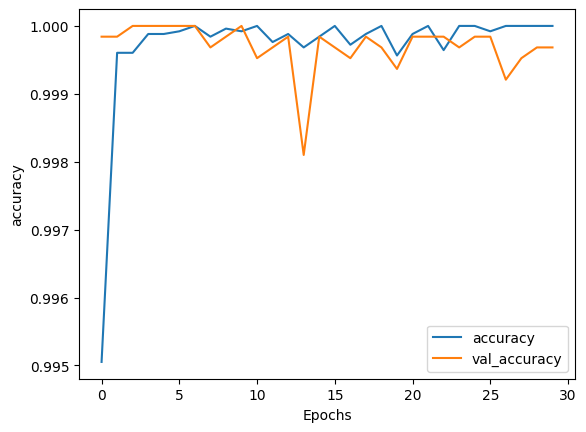

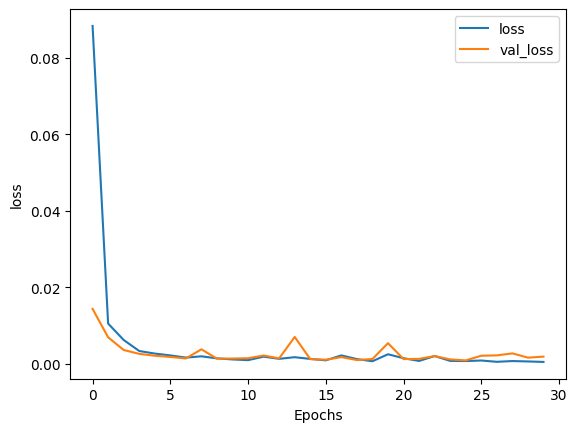

In [42]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Confusion Matrix
198/198 [==============================] - 1s 2ms/step
Threshold [0.5]
Accuracy for Test Data =  99.96832937450515


Text(95.72222222222221, 0.5, 'Expected')

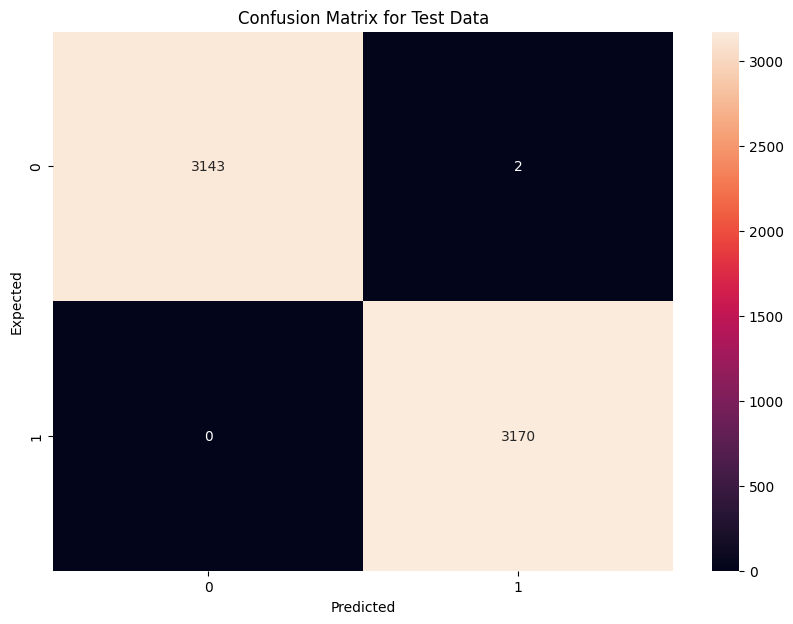

In [43]:
import seaborn
import pandas as pd
print('Confusion Matrix')
y_predicted = model.predict(X_test_pad)
print("Threshold",(min(y_predicted)+max(y_predicted))/2)
y_predicted_labels = y_predicted > 0.5
#print(y_predicted_labels)
size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )
cm = tf.math.confusion_matrix(y_test,y_predicted_labels)
cm_np = cm.numpy()
conf_acc = ((cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np)) * 100
print("Accuracy for Test Data = ", conf_acc)
plt.figure(figsize = (10,7))
seaborn.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix for Test Data")
plt.xlabel('Predicted')
plt.ylabel('Expected')